In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "My Drive/Practice"

[Errno 2] No such file or directory: 'My Drive/Practice'
/content/drive/My Drive/Practice


In [ ]:
!pip install transformers

In [ ]:
# imports

import os
import torch
import random
import statistics
import tokenizers
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler
from transformers import BertPreTrainedModel, RobertaConfig, RobertaModel, AdamW
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

In [ ]:
max_len = 108
hidden_size = 768
batch_size = 32
epochs = 5
lr = 2.5e-5
dropout_rate = 0.0
hidden_dropout_prob = 0.1
attention_probs_dropout_prob = 0.2
num_classes = 2
n_splits = 5
random_seed = 42
warmup_steps = 199

tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab='vocab.json', 
    merges='merges.txt', 
    lowercase=True,
    add_prefix_space=False
)

In [ ]:
chars = [".", "!", "?"]

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def find_sub_list(l,sl):
    """
    returns all occurences of sublist sl in list l
    i.e. their start and end position
    e.g.[(0, 4), (5, 9)]
    """
    
    if len(sl) == 0:
        return []
    
    else:
        results=[]
        sll=len(sl)
        for ind in (i for i,e in enumerate(l) if e==sl[0]):
            if l[ind:ind+sll]==sl:
                results.append((ind,ind+sll))

        return results
    
def findOccurrences(s, ch):
    occ = [i for i, letter in enumerate(s) if letter == ch]
    return occ, len(occ)

def preprocess_train(train_df):

    # make a copy of original text and selected_text
    train_df["preprocessed_text"] = train_df["text"]
    train_df["preprocessed_selected_text"] = train_df["selected_text"]

    # add space in the beggining
    train_df["preprocessed_text"] = train_df["preprocessed_text"].apply(lambda x: " " + x if x[0] != " " else x)
    

    # Sample: bye... -> bye. . .
    for i, (text, selected_text) in enumerate(zip(train_df.preprocessed_text.values, 
                                              train_df.preprocessed_selected_text.values)):
        spaces = []
    
        for char in chars:
            idxs, num_idxs = findOccurrences(text, char)
            if num_idxs > 1:
                for pos in range(num_idxs-2, -1, -1):
                    if idxs[pos] == idxs[pos+1]-1:
                        text = text[:idxs[pos]+1] + " " + text[idxs[pos]+1:]
                        spaces.append(char)
        if any(spaces):
            train_df.loc[i, "preprocessed_text"] = text
    
        for char in chars:
            idxs, num_idxs = findOccurrences(selected_text, char)
            if num_idxs > 1:
                for pos in range(num_idxs-2, -1, -1):
                    if idxs[pos] == idxs[pos+1]-1:
                        selected_text = selected_text[:idxs[pos]+1] + " " + selected_text[idxs[pos]+1:]
    
        train_df.loc[i, "preprocessed_selected_text"] = selected_text
    
    for i, (text, selected_text) in enumerate(zip(train_df.preprocessed_text.values, 
                                              train_df.preprocessed_selected_text.values)):
       
        text_tokenized = tokenizer.encode(text).tokens
        selected_tokenized = tokenizer.encode(selected_text).tokens
        subi_spl = find_sub_list(text_tokenized, selected_tokenized)
    
        selected_tokenized1 = tokenizer.encode(" " + selected_text).tokens
        subi_spl1 = find_sub_list(text_tokenized, selected_tokenized1)
        
        if len(subi_spl) == 0 and len(subi_spl1) > 0:
            train_df.loc[i, "preprocessed_selected_text"] = " " + selected_text
        

    for i, (text, selected_text) in enumerate(zip(train_df.preprocessed_text.values, 
                                              train_df.preprocessed_selected_text.values)):
       
        text_tokenized = tokenizer.encode(text).tokens
        selected_tokenized = tokenizer.encode(selected_text).tokens
        subi_spl = find_sub_list(text_tokenized, selected_tokenized)
    
        if len(subi_spl) == 0:
            start = text.find(selected_text)
            end = start + len(selected_text)
            for s in range(start-1, -1, -1):
                if text[s] != " ":
                    selected_text = text[s] + selected_text
                else:
                    selected_text = " " + selected_text
                    break
            for s in range(end, len(text)):
                if text[s] != " ":
                    selected_text = selected_text + text[s] 
                else:
                    break
        train_df.loc[i, "preprocessed_selected_text"] = selected_text
        
    
    for i, (text, selected_text) in enumerate(zip(train_df.preprocessed_text.values, 
                                              train_df.preprocessed_selected_text.values)):
       
        text_tokenized = tokenizer.encode(text).tokens
        selected_tokenized = tokenizer.encode(selected_text).tokens
        subi_spl = find_sub_list(text_tokenized, selected_tokenized)
        
        if len(subi_spl) == 0:
            train_df.drop(i, inplace=True)

    train_df.reset_index(drop=True, inplace=True)

def preprocess_test(test_df):
    # I STEP
    # make a copy of original text and selected_text
    test_df["preprocessed_text"] = test_df["text"]
    # add space at the begginings
    test_df["preprocessed_text"] = test_df["preprocessed_text"].apply(lambda x: " " + x if x[0] != " " else x)   
    
    # II STEP
    for i, text in enumerate(test_df.preprocessed_text.values):
        spaces = []
        for char in chars:
            idxs, num_idxs = findOccurrences(text, char)
            if num_idxs > 1:
                for pos in range(num_idxs-2, -1, -1):
                    if idxs[pos] == idxs[pos+1]-1:
                        text = text[:idxs[pos]+1] + " " + text[idxs[pos]+1:]
                        spaces.append(char)
        if any(spaces):
            test_df.loc[i, "preprocessed_text"] = text    
    
def get_labels(tokens, pr_selected_text):
    
    start_labels = [0] * len(tokens)
    end_labels = [0] * len(tokens)

    selected_tokens = tokenizer.encode(pr_selected_text).tokens
    subi = find_sub_list(tokens, selected_tokens)
    assert len(subi) > 0, "Something is wrong!!!"
    
    start, end = subi[0]
    start_labels[start] = 1
    end_labels[end-1] = 1
    
    start_labels = [0] * 4 + start_labels + [0]
    end_labels = [0] * 4 + end_labels + [0]

    return start_labels, end_labels


def process_sample(text, pr_text, sentiment, max_len, tokenizer, selected_text=None, pr_selected_text=None):
    """
    gets all info for one sample
    """
    sentiment_id = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }
    
    info = tokenizer.encode(pr_text)
    
    input_ids = [0] + [sentiment_id[sentiment]] + [2] + [2] + info.ids + [2]    
    attention_mask = [1] * len(input_ids)
    tokens = info.tokens
    offsets = info.offsets
    
    loss_mask = [0] * 4 + [1] * len(tokens) + [0]
                
    if selected_text is not None:
        start_labels, end_labels = get_labels(tokens, pr_selected_text)
    else: start_labels, end_labels = None, None
        
    pad_len = max_len - len(input_ids)
    if pad_len > 0:
        input_ids = input_ids + ([1] * pad_len)
        attention_mask = attention_mask + ([0] * pad_len)
        loss_mask = loss_mask + ([0] * pad_len)
        
        if selected_text is not None:
            start_labels = start_labels + ([0] * pad_len)
            end_labels = end_labels + ([0] * pad_len)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "loss_mask": loss_mask,
        "tokens": tokens,
        "start_labels": start_labels,
        "end_labels": end_labels,
        "offsets": offsets,
        "text": text,
        "preprocessed_text": pr_text,
        "selected_text": selected_text,
        "preprocessed_selected_text": pr_selected_text,
        "sentiment": sentiment
    }

def tweet_loss(start_logits, start_labels, end_logits, end_labels, loss_mask):

    loss_fn = nn.BCEWithLogitsLoss()

    # mask actives
    actives = loss_mask.reshape(-1) == 1
    # apply the masks
    start_logits = start_logits.reshape(-1)[actives]
    start_labels = start_labels.reshape(-1)[actives]
    end_logits = end_logits.reshape(-1)[actives]
    end_labels = end_labels.reshape(-1)[actives]
        
    start_loss =  loss_fn(start_logits, start_labels.type_as(start_logits))
    end_loss =  loss_fn(end_logits, end_labels.type_as(end_logits))    
    
    return (start_loss + end_loss) / 2


def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


class TweetDataset:
    
    max_len = max_len
    tokenizer = tokenizer
    
    def __init__(self, df, sentiment_values=None):
        if sentiment_values is not None:
            df = df.loc[df.sentiment.isin(sentiment_values)].reset_index(drop=True)
        self.df = df
        self.indexs = df.index.values
        self.text = df.text.values
        self.preprocessed_text = df.preprocessed_text.values
        self.sentiments = df.sentiment.values
        if "selected_text" in df:
            self.selected_text = df.selected_text.values
            self.preprocessed_selected_text = df.preprocessed_selected_text.values
        else:
            self.selected_text = None
            self.preprocessed_selected_text = None
        
    def __len__(self):
        return len(self.indexs)
        
    def __getitem__(self, idx):
        if self.selected_text is not None:
            return process_sample(self.text[idx], self.preprocessed_text[idx], self.sentiments[idx], self.max_len,
                                self.tokenizer, self.selected_text[idx], self.preprocessed_selected_text[idx])
        else:
            return process_sample(self.text[idx], self.preprocessed_text[idx], self.sentiments[idx], self.max_len,
                                self.tokenizer)
    
    def get_metadata(self):
        
        return [self[i] for i in range(len(self))]
    
    def get_train_dataloader(self, idxs):
        
        input_ids_all = []
        attention_mask_all = []
        loss_mask_all = []
        start_labels_all = []
        end_labels_all = []
        
        for i in idxs:
            
            sample = self[i]
        
            input_ids_all.append(sample["input_ids"])
            attention_mask_all.append(sample["attention_mask"])
            loss_mask_all.append(sample["loss_mask"])
            start_labels_all.append(sample["start_labels"])
            end_labels_all.append(sample["end_labels"])

        data = TensorDataset(torch.LongTensor(input_ids_all),
                             torch.FloatTensor(attention_mask_all),
                             torch.LongTensor(loss_mask_all),
                             torch.LongTensor(start_labels_all),
                             torch.LongTensor(end_labels_all)
                                    )
        
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size) 

        return dataloader
    
    def get_test_dataloader(self):
        
        input_ids_all = []
        attention_mask_all = []
        loss_mask_all = []
        
        for i in self.indexs:
            
            sample = self[i]
        
            input_ids_all.append(sample["input_ids"])
            attention_mask_all.append(sample["attention_mask"])
            loss_mask_all.append(sample["loss_mask"])

        data = TensorDataset(torch.LongTensor(input_ids_all),
                             torch.FloatTensor(attention_mask_all),
                             torch.LongTensor(loss_mask_all)
                                  )
        
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size) 

        return dataloader
    
class TweetModel(BertPreTrainedModel):
    
    def __init__(self, conf):
        super(TweetModel, self).__init__(conf)
        self.roberta = RobertaModel.from_pretrained('pytorch_model.bin', config=conf)
        self.drop_out = nn.Dropout(dropout_rate)
        self.clf = nn.Linear(hidden_size, num_classes)
        nn.init.normal_(self.clf.weight, std=0.02)
        
    def forward(self, input_ids, attention_mask):
        
        sequence_outputs, _ = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
                
        sequence_outputs = self.drop_out(sequence_outputs)
        logits = self.clf(sequence_outputs)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        return start_logits, end_logits

def prepare_predictions(pp):
    for char in chars:
        idxs, num_idxs = findOccurrences(pp, char)
        if num_idxs > 1:
            for pos in range(num_idxs-2, -1, -1):
                if idxs[pos] == idxs[pos+1] - 2 :
                    pp = pp[:idxs[pos]+1] + pp[idxs[pos+1]:]
             
    return pp


In [ ]:
seed_everything(random_seed)

train_path = "train.csv"
test_path = "test.csv"

train_raw = pd.read_csv(train_path).dropna().reset_index(drop=True)
test_raw = pd.read_csv(test_path)

print(f"train data: {train_raw.shape}")
print(f"test data: {test_raw.shape}")

train data: (27480, 4)
test data: (3534, 3)


In [ ]:
# get only negative and positive sentiment samples
train_df = train_raw.loc[train_raw.sentiment != "neutral"].reset_index(drop=True, inplace=False)
test_df = test_raw.loc[test_raw.sentiment != "neutral"].reset_index(drop=True, inplace=False)
print(f"non neutral train data: {train_df.shape}")
print(f"non neutral test data: {test_df.shape}")

non neutral train data: (16363, 4)
non neutral test data: (2104, 3)


In [ ]:
train_df.head()

,textID,text,selected_text,sentiment
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
1,088c60f138,my boss is bullying me...,bullying me,negative
2,9642c003ef,what interview! leave me alone,leave me alone,negative
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive


In [ ]:
test_df.head()

,textID,text,sentiment
0,96d74cb729,Shanghai is also really exciting (precisely -...,positive
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
2,01082688c6,happy bday!,positive
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
4,726e501993,that`s great!! weee!! visitors!,positive


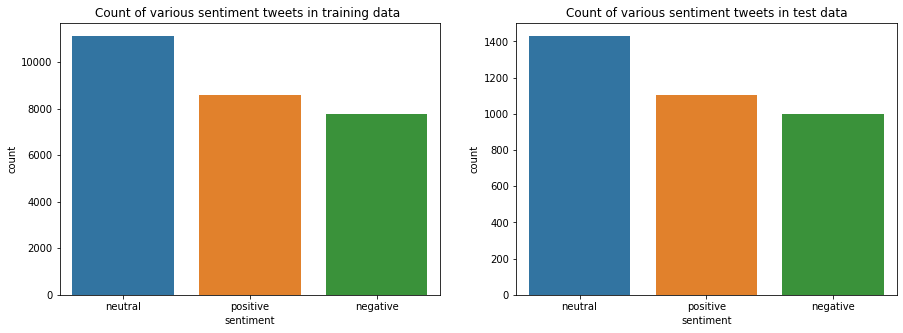

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sb

f, axes = plt.subplots(1, 2,figsize=(15,5))

sb.countplot(x='sentiment',data=train_raw,order=train_raw.sentiment.value_counts().index,ax=axes[0]).set_title('Count of various sentiment tweets in training data ')

sb.countplot(x='sentiment',data=test_raw,order=test_raw.sentiment.value_counts().index,ax=axes[1])
plt.title('Count of various sentiment tweets in test data');

In [ ]:

#Lowercase

train_df['text']= train_df['text'].apply(lambda x: x.lower())
test_df['text']= test_df['text'].apply(lambda x: x.lower())
train_df['selected_text']= train_df['selected_text'].apply(lambda x: x.lower())

#Removing Hyper-Links
import re
def remove_hyperlinks(text):
  hyperlinkfree=re.sub('https?://\S+|www\.\S+', '', text)
  return hyperlinkfree
train_df['text']=train_df['text'].apply(lambda x:remove_hyperlinks(x))
test_df['text']=test_df['text'].apply(lambda x:remove_hyperlinks(x))
train_df['selected_text']=train_df['selected_text'].apply(lambda x:remove_hyperlinks(x))

#Removing Numbers, Angular Brackets, Square Brackets, ‘\n’ character
#Replacing **** by <ABUSE> word
def remove(text):
  text=re.sub('\S*\d\S*',' ',text) #Removing Numbers
  text=re.sub('<.*?>+',' ',text)   #Removing Angular Brackets
  text=re.sub('\[.*?\]',' ',text)  #Removing Square Brackets
  text=re.sub('\n',' ',text)       #Removing '\n' character 
  text=re.sub('\*+','<ABUSE>',text) #Replacing **** by ABUSE word
  return text

train_df['text']=train_df['text'].apply(lambda x:remove(x))
test_df['text']=test_df['text'].apply(lambda x:remove(x))
train_df['selected_text']=train_df['selected_text'].apply(lambda x:remove(x))

#Spelling Correction
def wrong_words(text,selected):
  words=[]
  text=text.split()
  selected=selected.split()
  for i in selected:dx
    if i not in text:
      words.append(i)
  if len(words)>0:
    return " ".join(words)
  else:
    return '++++'
train_df['spelling']=train_df.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

def remove_text(x):
  selected=x[0]
  spelling=x[1]
  selected=selected.split()
  selected.remove(spelling) 
  return " ".join(selected)
train_df['selected_text']=train_df[['selected_text','spelling']].apply(lambda x: remove_text(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)
train_df['spelling']=train_df.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

!pip install fuzzywuzzy

from fuzzywuzzy import fuzz
def matching(x):
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()
  selected=selected.split()
  spelling=spelling.split()
  for s in spelling:
    for t in text:
      if s in selected:
        if(fuzz.ratio(t,s)>55): 
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected)   
train_df['selected_text']=train_df[['text','selected_text','spelling']].apply(lambda x: matching(x) if x['spelling']!='++++'  else x['selected_text'],axis=1)
  

In [ ]:
%%time

preprocess_train(train_df)
preprocess_test(test_df)

CPU times: user 44.9 s, sys: 1.83 s, total: 46.7 s
Wall time: 49 s


In [ ]:
train_dataset = TweetDataset(train_df)
test_dataset = TweetDataset(test_df)

train_metadata = train_dataset.get_metadata()
test_metadata = test_dataset.get_metadata()

In [ ]:
def train_loop():
    
    # create splits
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_seed, shuffle=True)
    
    # lists to store oof predictions
    val_start_logits = [0 for tm in train_metadata]
    val_end_logits = [0 for tm in train_metadata]
    
    # lists to accumulate folds test set predictions
    test_start_logits = [torch.zeros(len(tm["input_ids"]), dtype=torch.float) for tm in test_metadata]
    test_end_logits = [torch.zeros(len(tm["input_ids"]), dtype=torch.float) for tm in test_metadata]
    
    test_dataloader = test_dataset.get_test_dataloader()
    for fold_idx, (train_idxs, val_idxs) in enumerate(kf.split(X=train_dataset.df, 
                                                               y=train_dataset.df.sentiment.values)):
                        
        # create dataloaders
        train_dataloader = train_dataset.get_train_dataloader(train_idxs)
        val_dataloader = train_dataset.get_train_dataloader(val_idxs)
        
        # model init
        model_config = RobertaConfig.from_pretrained('config.json', lowercase=True)
        model_config.hidden_dropout_prob = hidden_dropout_prob
        model_config.attention_probs_dropout_prob = attention_probs_dropout_prob
        model = TweetModel(conf=model_config)
        model.cuda()
        
        # optimizer init
        optimizer = AdamW(model.parameters(), lr=lr)
        num_train_steps = epochs * len(train_dataloader)
        # create the learning rate scheduler
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, 
                                            num_train_steps)
        
        for epoch in range(epochs):
            
            model.train()
            
            for batch in train_dataloader:
                
                # add batch to GPU
                batch = tuple(t.to(device) for t in batch) 
                
                input_ids, attention_mask, loss_mask, start_labels, end_labels = batch
                                
                start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask)
                
                # calculate loss
                loss = tweet_loss(start_logits, start_labels, end_logits, end_labels, loss_mask)
                
                # calculate gradients
                loss.backward()               
                # update model param
                optimizer.step()
                # update lr
                scheduler.step()
                # clean the gradients
                model.zero_grad()
            
        # save validation and test logits
        model.eval()
        
        val_fold_start_logits = []
        val_fold_end_logits = []
        
        for batch in val_dataloader:
            # add batch to GPU
            batch = tuple(t.to(device) for t in batch) 
                
            input_ids, attention_mask, loss_mask, start_labels, end_labels = batch
    
            with torch.no_grad():
                start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
            batch_start_logits = [start_logits[s].cpu() for s in range(input_ids.shape[0])]
            batch_end_logits = [end_logits[s].cpu() for s in range(input_ids.shape[0])]
    
            val_fold_start_logits += batch_start_logits
            val_fold_end_logits += batch_end_logits
        
        for e, idx in enumerate(val_idxs):
            val_start_logits[idx] = val_fold_start_logits[e]
            val_end_logits[idx] = val_fold_end_logits[e]
        
        test_fold_start_logits = []
        test_fold_end_logits = []
        
        for batch in test_dataloader:
            # add batch to GPU
            batch = tuple(t.to(device) for t in batch) 
                
            input_ids, attention_mask, loss_mask = batch
    
            with torch.no_grad():
                start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
            batch_start_logits = [start_logits[s].cpu() for s in range(input_ids.shape[0])]
            batch_end_logits = [end_logits[s].cpu() for s in range(input_ids.shape[0])]
    
            test_fold_start_logits += batch_start_logits
            test_fold_end_logits += batch_end_logits
        
        for e in range(len(test_dataset)):
            test_start_logits[e] += test_fold_start_logits[e].squeeze(1)
            test_end_logits[e] += test_fold_end_logits[e].squeeze(1)
            
        print("one fold over!")
           
    return val_start_logits, val_end_logits, test_start_logits, test_end_logits


In [ ]:
%%time

# set the device to GPU
device = torch.device("cuda")

val_start_logits, val_end_logits, test_start_logits, test_end_logits = train_loop()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


one fold over!
one fold over!


In [ ]:
jaccs = []
predictions = []
br = 0    
for e, meta in enumerate(train_metadata):
    
    text = meta["text"]
    preprocessed_text = meta["preprocessed_text"]
    selected_text = meta["selected_text"]
    loss_mask = meta["loss_mask"]
    tokens = meta["tokens"]
    offsets = meta["offsets"]
    
    actives = np.asarray(meta["loss_mask"]).reshape(-1) == 1
    start_probs = val_start_logits[e][actives].sigmoid()
    end_probs = val_end_logits[e][actives].sigmoid()
        
    start_idx = start_probs.argmax().item()
    end_idx = end_probs.argmax().item()
    
    if start_idx > end_idx:
        br += 1
        start_idx , end_idx = 0, start_probs.shape[0]-1
    
    start_max = start_probs.max().item()
    end_max = end_probs.max().item()        

    pp = preprocessed_text[offsets[start_idx][0]:offsets[end_idx][1]]
    
    if pp not in text or pp not in " " + text:
        pp = prepare_predictions(pp)
    
    predictions.append(pp)
    jaccs.append(jaccard(selected_text, pp))

print('Mean Jaccard score for positive and negative sentiment tweets: ', round(statistics.mean(jaccs),4))
print('Mean Jaccard score for neutral tweets: 0.9767')
print('Mean Jaccard score: ', round(statistics.mean(jaccs)*0.5955+0.9767*0.4045,4))

In [ ]:
test_raw["selected_text"] = "" # make a column for predictions

# make predictions for neutral sentiment
test_raw.loc[test_raw.sentiment == "neutral", "selected_text"] = test_raw.loc[test_raw.sentiment == "neutral", "text"]


In [ ]:
# get positive and negative sentiment predictions

predictions = []
br = 0    
for e, meta in enumerate(test_metadata):
    
    text = meta["text"]
    preprocessed_text = meta["preprocessed_text"]
    loss_mask = meta["loss_mask"]
    tokens = meta["tokens"]
    offsets = meta["offsets"]
    
    actives = np.asarray(meta["loss_mask"]).reshape(-1) == 1
    start_probs = test_start_logits[e][actives].sigmoid()
    end_probs = test_end_logits[e][actives].sigmoid()
        
    start_idx = start_probs.argmax().item()
    end_idx = end_probs.argmax().item()
    
    if start_idx > end_idx:
        br += 1
        start_idx , end_idx = 0, start_probs.shape[0]-1       

    pp = preprocessed_text[offsets[start_idx][0]:offsets[end_idx][1]]
    
    if pp not in text or pp not in " " + text:
        pp = prepare_predictions(pp)
    
    predictions.append(pp)


In [ ]:
# make predictions for neutral sentiment
test_raw.loc[test_raw.sentiment != "neutral", "selected_text"] = predictions


In [ ]:
submission = test_raw.drop(columns = ["text", "sentiment"])
submission.to_csv("submission.csv", index=False)

In [ ]:
print(submission)